In [1]:
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import yaml

from hydesign.assembly.hpp_assembly import hpp_model
from hydesign.examples import examples_filepath

In [2]:
sites = pd.read_csv('hopp_input/34.22_-102.75_psmv3_60_2013.csv', index_col=0)
example = 0

ex_site = sites.iloc[int(example),:]

print('Selected example site:')
print('---------------------------------------------------')
print(ex_site.T)

longitude = float(ex_site['Longitude'])
latitude = float(ex_site['Latitude'])
altitude = float(ex_site['Elevation'])
input_ts_fn = os.path.join(os.getcwd(), 'hydesign_input/input_ts_texas.csv')
sim_pars_fn = os.path.join(os.getcwd(), 'hydesign_input/hpp_pars_converted.yml')

hpp = hpp_model(
        sim_pars_fn,
        latitude = latitude,
        longitude = longitude,
        altitude = altitude,
        num_batteries = 10,
        work_dir = './',
        input_ts_fn = input_ts_fn,
        save_battry_rf_filename='battery_rf.csv',
)

with open(sim_pars_fn, 'r') as f:
    sim_pars = yaml.safe_load(f)

inputs = dict(
clearance = sim_pars['hh'] - sim_pars['d'] / 2,
sp = (4 * sim_pars['p_rated'] * 1e6) / (np.pi * (sim_pars['d'] ** 2)),
p_rated = sim_pars['p_rated'],
Nwt	=	175,
wind_MW_per_km2 = 4.782274215,
solar_MW =	500,
surface_tilt =	90,
surface_azimuth = 90,
DC_AC_ratio	= 1 ,
b_P = 100,
b_E_h=	1,
cost_of_battery_P_fluct_in_peak_price_ratio	=0.000,)

Selected example site:
---------------------------------------------------
Location ID                                   543124
City                                               -
State                                              -
Country                                            -
Latitude                                       34.21
Longitude                                    -102.74
Time Zone                                         -6
Elevation                                       1178
Local Time Zone                                   -6
Clearsky DHI Units                              w/m2
Clearsky DNI Units                              w/m2
Clearsky GHI Units                              w/m2
Dew Point Units                                    c
DHI Units                                       w/m2
DNI Units                                       w/m2
GHI Units                                       w/m2
Solar Zenith Angle Units                      Degree
Temperature Units       

In [3]:
start = time.time()
outs = hpp.evaluate(**inputs)
hpp.print_design([v for k,v in inputs.items()], outs)
end = time.time()
print('exec. time [min]:', (end - start)/60 )
print(hpp.prob['NPV_over_CAPEX'])


Design:
---------------
clearance [m]: 17.000
sp [W/m2]: 198.861
p_rated [MW]: 6.000
Nwt: 175.000
wind_MW_per_km2 [MW/km2]: 4.782
solar_MW [MW]: 500.000
surface_tilt [deg]: 90.000
surface_azimuth [deg]: 90.000
DC_AC_ratio: 1.000
b_P [MW]: 100.000
b_E_h [h]: 1.000
cost_of_battery_P_fluct_in_peak_price_ratio: 0.000


NPV_over_CAPEX: -0.724
NPV [MEuro]: -1253.508
IRR: 0.000
LCOE [Euro/MWh]: 73.820
Revenues [MEuro]: 77.107
CAPEX [MEuro]: 1732.000
OPEX [MEuro]: 36.615
Wind CAPEX [MEuro]: 1152.900
Wind OPEX [MEuro]: 27.090
PV CAPEX [MEuro]: 495.500
PV OPEX [MEuro]: 8.600
Batt CAPEX [MEuro]: 68.600
Batt OPEX [MEuro]: 0.925
Shared CAPEX [MEuro]: 15.000
Shared OPEX [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 2331.267
GUF: 0.887
grid [MW]: 300.000
wind [MW]: 1050.000
solar [MW]: 500.000
Battery Energy [MWh]: 100.000
Battery Power [MW]: 100.000
Total curtailment [GWh]: 80927.799
Total curtailment with deg [GWh]: 81064.569
Awpp [km2]: 219.561
Apvp [km2]: 0.000
Plant area [km2]: 219.

In [4]:
import numpy_financial as npf
V = [-1685.4] + 25 * [4047.3/25 - 1172.28/25]
r = 0.064
npv = npf.npv(r, V)
npv

np.float64(-269.5609405121758)

Solar generation [MWh] 1222433.2151858164


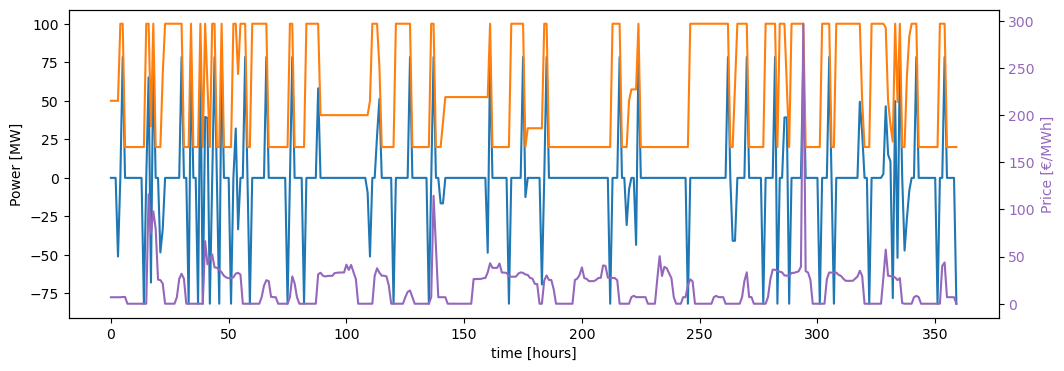

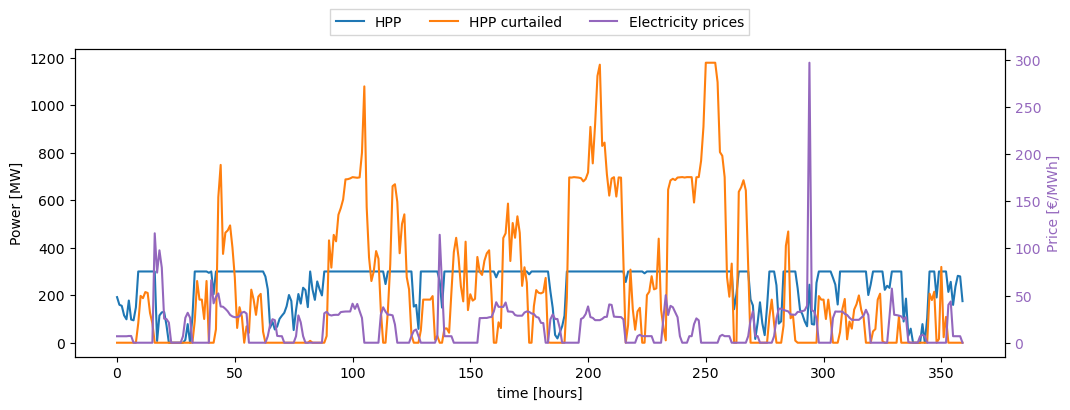

In [5]:
b_t = hpp.prob.get_val('ems.b_t')
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('pvp.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
price_t = hpp.prob.get_val('ems.price_t')

n_days_plot = 15
print("Solar generation [MWh]", sum(solar_t))

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(b_t[:24*n_days_plot], label='Battery')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')

ax2 = ax1.twinx()
ax2.plot(price_t[:24*n_days_plot], color='tab:purple', label='Electricity prices')
ax2.set_ylabel('Price [€/MWh]', color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(hpp_t[:24*n_days_plot], label='HPP')
ax1.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')

ax2 = ax1.twinx()
ax2.plot(price_t[:24*n_days_plot], color='tab:purple', label='Electricity prices')
ax2.set_ylabel('Price [€/MWh]', color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)

plt.show()

In [6]:
from hopp.simulation import HoppInterface
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

c:\Users\s223344\tool-benchmarking\North_America\Texas\log\hybrid_systems_2025-11-24T14.23.39.401046.log


In [7]:
hi = HoppInterface(os.path.join(os.getcwd(), "hopp_input/hopp_config.yaml"))

FLORIS is the system model...


ValueError: generator_efficiency is no longer supported as power is specified in absolute terms in FLORIS v4. Consider using the convert_turbine_v3_to_v4.py utility in floris/tools to convert from a FLORIS v3 turbine definition to FLORIS v4. See https://nrel.github.io/floris/v3_to_v4.html for more information.

In [ ]:
hi.system.wind._financial_model.FinancialParameters.real_discount_rate = 6
hi.system.pv._financial_model.FinancialParameters.real_discount_rate = 6
hi.system.battery._financial_model.FinancialParameters.real_discount_rate = 6
hi.system.grid._financial_model.FinancialParameters.real_discount_rate = 6

hi.system.wind._financial_model.FinancialParameters.inflation_rate = 2
hi.system.pv._financial_model.FinancialParameters.inflation_rate = 2
hi.system.battery._financial_model.FinancialParameters.inflation_rate = 2
hi.system.grid._financial_model.FinancialParameters.inflation_rate = 2

# Federal tax rate 21%, set state tax rate to 4% (total 25% tax rate)
hi.system.wind._financial_model.FinancialParameters.state_tax_rate = [4]*25
hi.system.pv._financial_model.FinancialParameters.state_tax_rate = [4]*25
hi.system.battery._financial_model.FinancialParameters.state_tax_rate = [4]*25
hi.system.grid._financial_model.FinancialParameters.state_tax_rate = [4]*25

In [ ]:
hi.simulate(25)

Simulating wind farm output in FLORIS...


In [ ]:
hybrid_plant = hi.system

annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
cf = hybrid_plant.capacity_factors
total_revenue = hybrid_plant.grid.total_revenue
revenue_gen = np.array(hybrid_plant.grid._financial_model.value('revenue_gen')) / 1e3
generation_profile = hybrid_plant.grid.generation_profile

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
battery_installed_cost = hybrid_plant.battery.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost
OM_cost = hybrid_plant.om_total_expenses
generation_curtailed = hybrid_plant.grid.generation_curtailed

print("Wind Installed Cost [M$]: {}".format(wind_installed_cost/1e6))
print("Solar Installed Cost [M$]: {}".format(solar_installed_cost/1e6))
print("Battery Installed Cost [M$]: {}".format(battery_installed_cost/1e6))
print("Hybrid Installed Cost [M$]: {}\n".format(hybrid_installed_cost/1e6))
print("OPEX [$/year]", OM_cost)
print("Total OPEX[M$]", sum(OM_cost["hybrid"])/1e6)

print("Wind NPV [M$]: {}".format(hybrid_plant.net_present_values.wind/1e6))
print("Solar NPV [M$]: {}".format(hybrid_plant.net_present_values.pv/1e6))
print("Hybrid NPV [M$]: {}\n".format(hybrid_plant.net_present_values.hybrid/1e6))

print("Annual Energies [GWh]", annual_energies)
print("Capacity Factors", cf)
print("NPV [$]", npvs)
print("Total Revenue (HyDesign method) [M$]", np.sum(hpp_t[0:8760] * hpp.prob.get_val('ems.price_t')[0:8760]) / 1e6)
print("Total Revenue (HOPP method) [M$]", np.sum(np.array(hi.system.grid._financial_model.value('revenue_gen')[0:8760]) / 1e3 * np.array(hi.system.grid._financial_model.value('dispatch_factors_ts')[0:8760]) * np.array(hi.system.grid._financial_model.value('ppa_price_input'))) / 1e6)
print("Total Energy sold [GWh]", np.sum(revenue_gen) / 1e3)
print("PPA price input", hi.system.grid._financial_model.value('ppa_price_input'))

print("LCOE [cents/kWh]", hybrid_plant.lcoe_real,"\n")

print(hybrid_plant.lcoe_real['hybrid'])
print("Hybrid LCOE [$/MWh]", hybrid_plant.lcoe_real['hybrid']*10)

print("Grid Curtailment [%]:", hybrid_plant.grid.curtailment_percent)

Wind Installed Cost [M$]: 1152.9
Solar Installed Cost [M$]: 495.5
Battery Installed Cost [M$]: 37.0
Hybrid Installed Cost [M$]: 1685.4

OPEX [$/year] {"pv": [0.0, 8600000.0, 8772000.0, 8947440.0, 9126388.8, 9308916.576, 9495094.90752, 9684996.8056704, 9878696.741783807, 10076270.676619485, 10277796.090151874, 10483352.011954911, 10693019.05219401, 10906879.43323789, 11125017.02190265, 11347517.362340702, 11574467.709587516, 11805957.063779267, 12042076.205054853, 12282917.72915595, 12528576.083739068, 12779147.605413852, 13034730.557522127, 13295425.168672571, 13561333.672046024, 13832560.345486945], "wind": [0.0, 27090000.0, 27631800.000000004, 28184436.0, 28748124.720000006, 29323087.2144, 29909548.958688, 30507739.937861763, 31117894.736619, 31740252.631351378, 32375057.683978405, 33022558.837657977, 33683010.01441114, 34356670.21469936, 35043803.61899335, 35744679.691373214, 36459573.285200685, 37188764.750904694, 37932540.04592279, 38691190.846841246, 39465014.663778074, 40254314.

In [ ]:
# Export_to_Excel time series, if needed change the time series below.
revenue_gen = np.array(revenue_gen)
hpp_t = np.array(hpp_t)

length = min(len(revenue_gen), len(hpp_t))
revenue_gen = revenue_gen[:length]
hpp_t = hpp_t[:length]

df = pd.DataFrame({
    'revenue_gen': revenue_gen,
    'hpp_t': hpp_t
})

df.to_excel('compare_ts.xlsx', index=False)

print("Export done.xlsx")

Export done.xlsx


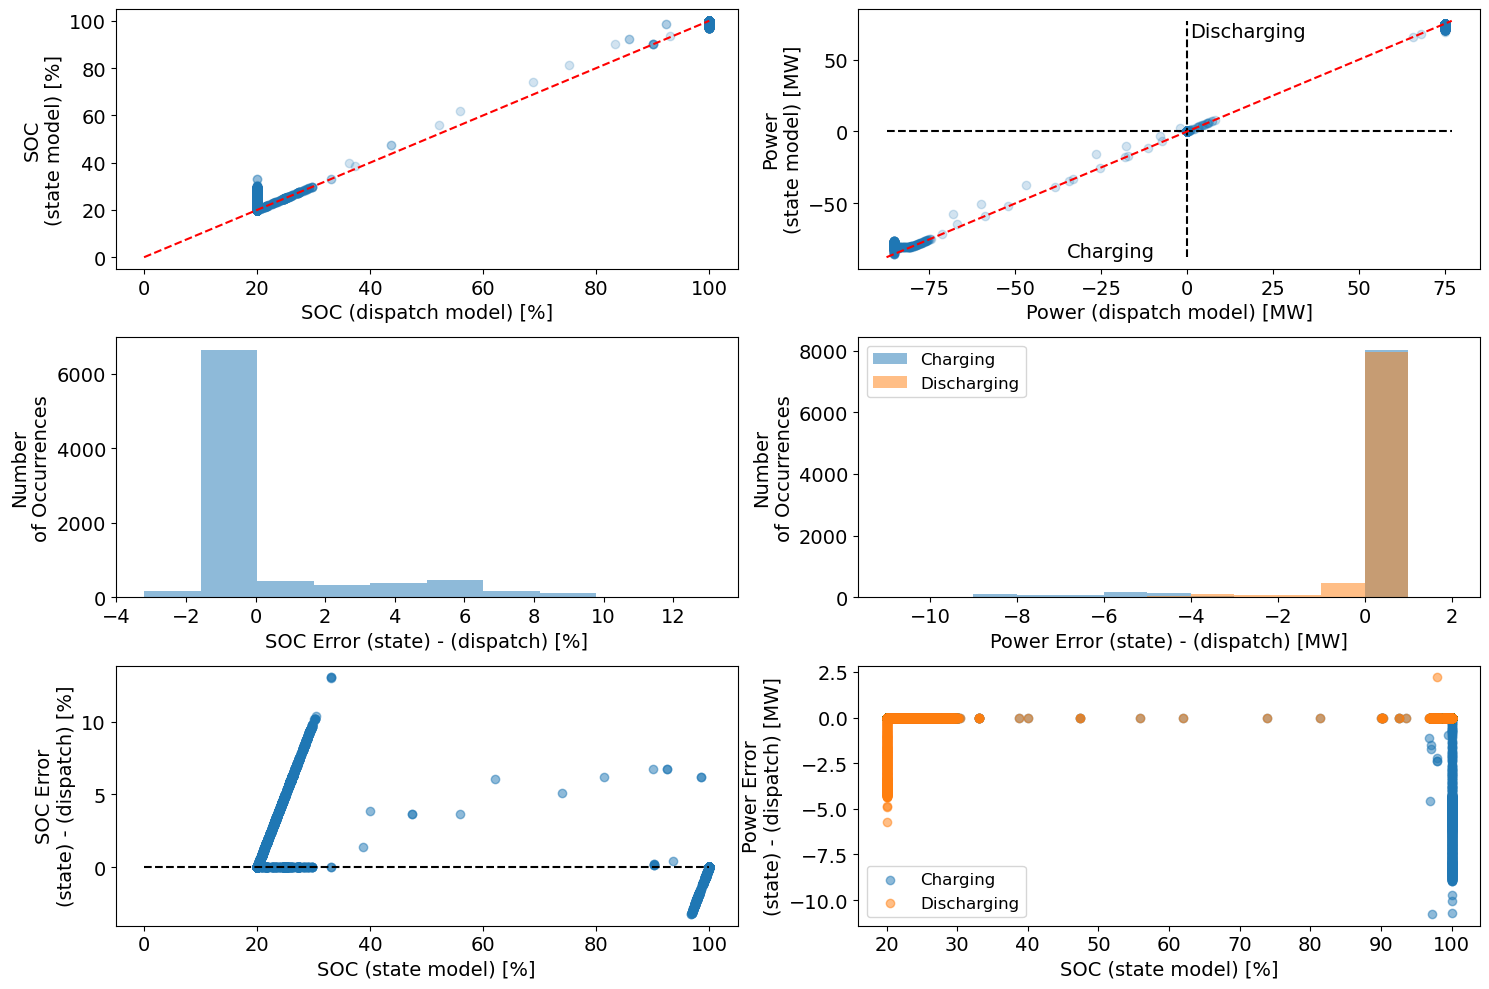

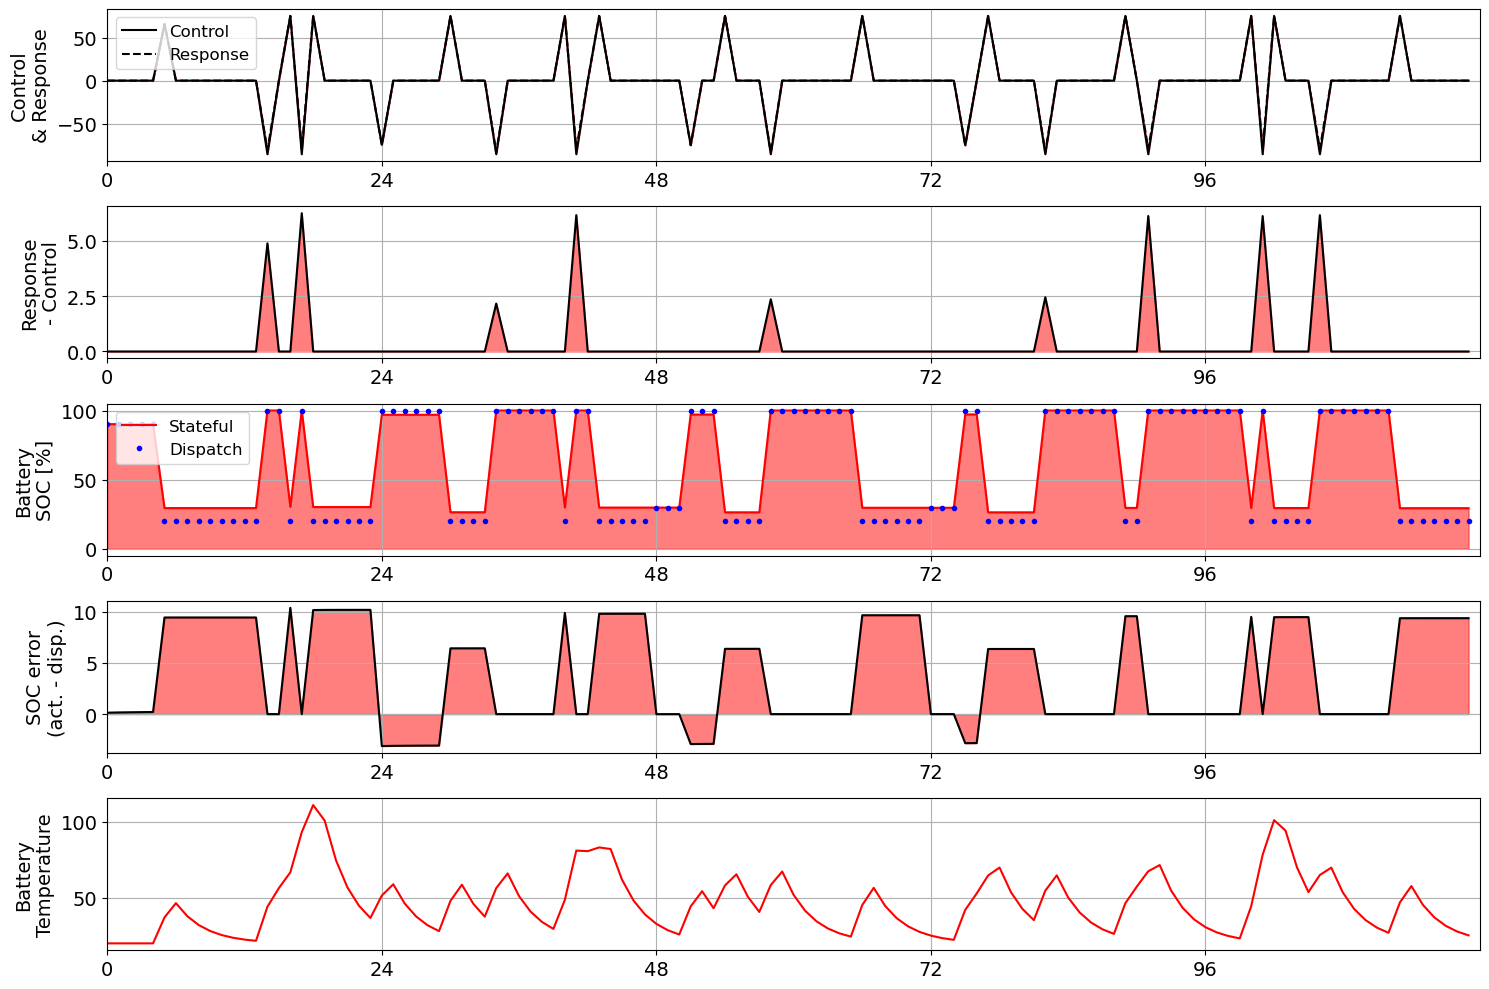

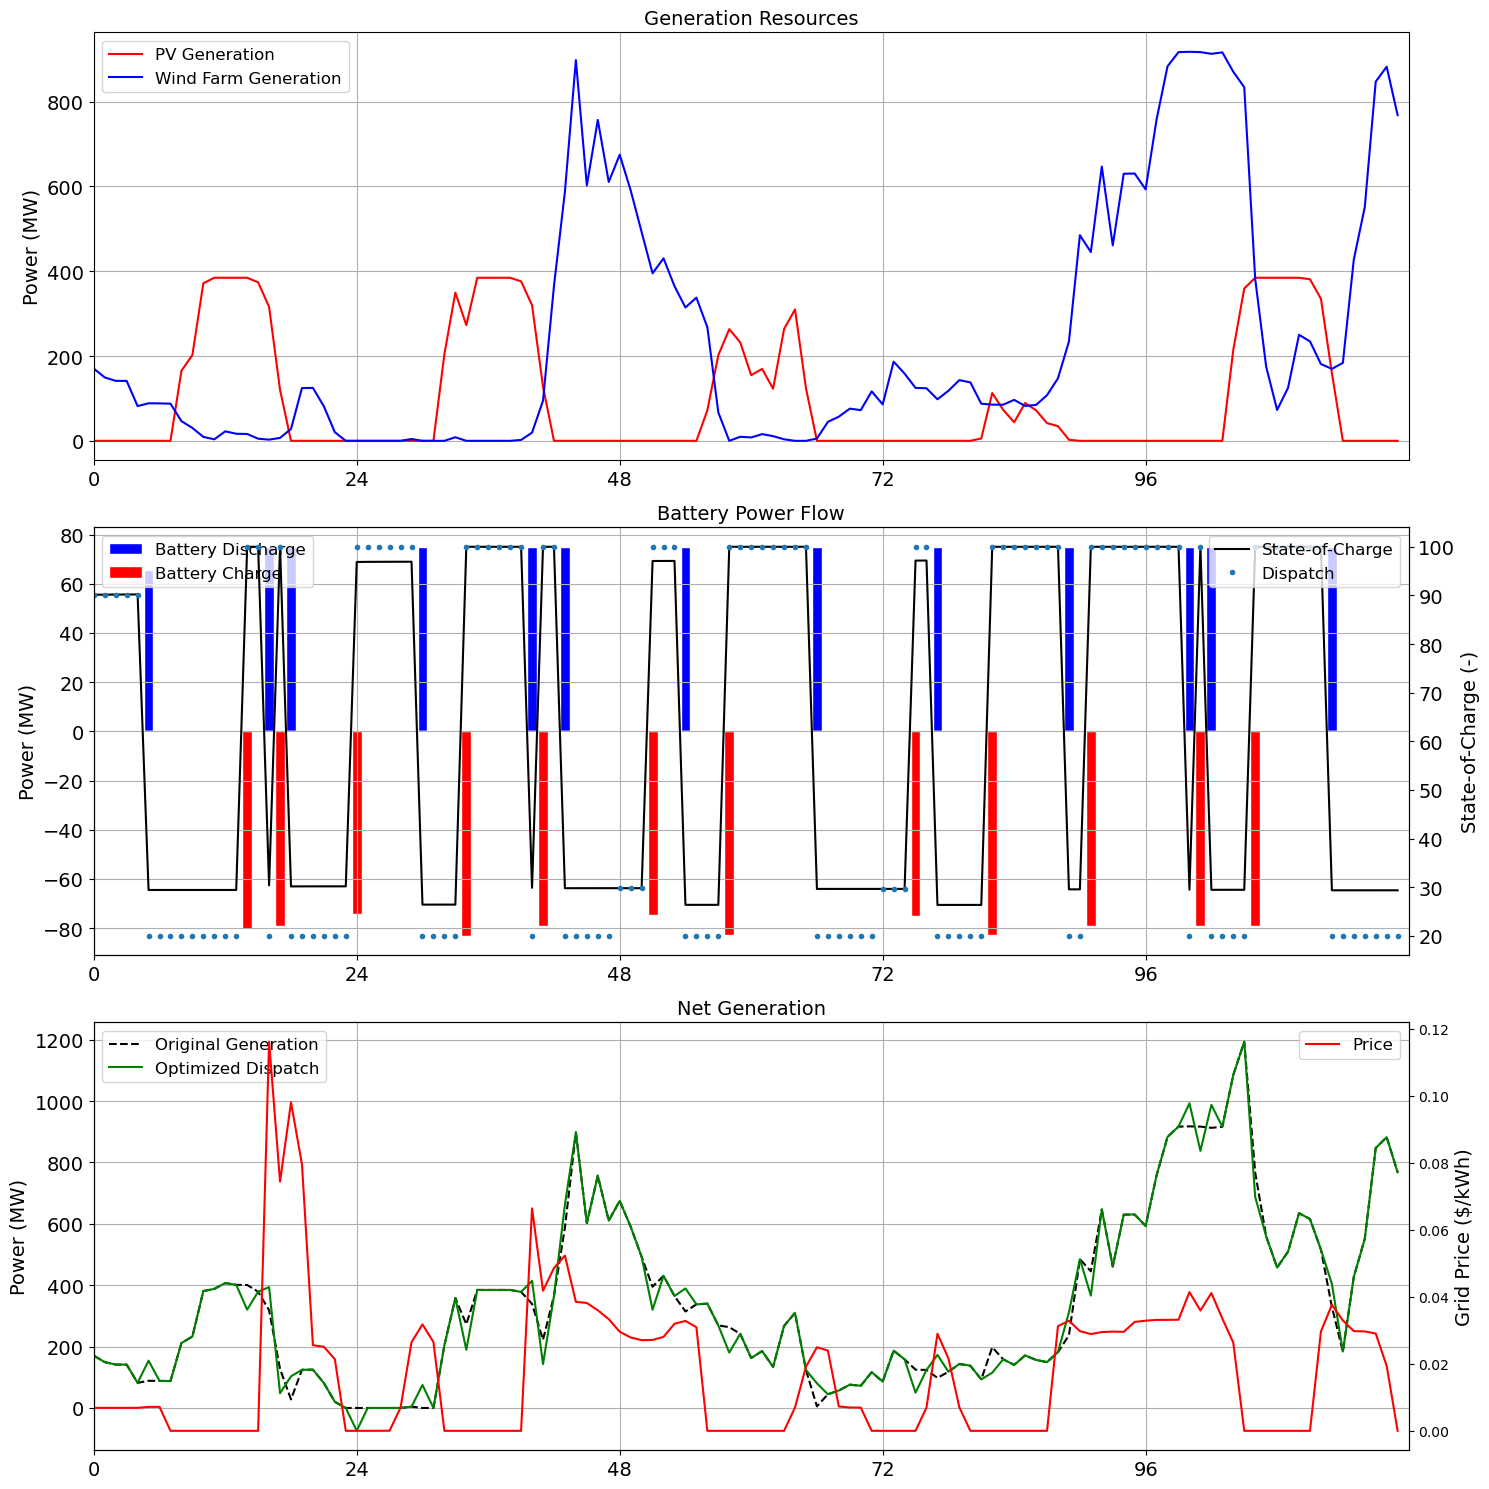

In [ ]:
#Plot different battery and generation indicators/profiles in the HOPP model
plot_battery_dispatch_error(hybrid_plant)
plot_battery_output(hybrid_plant)
plot_generation_profile(hybrid_plant)

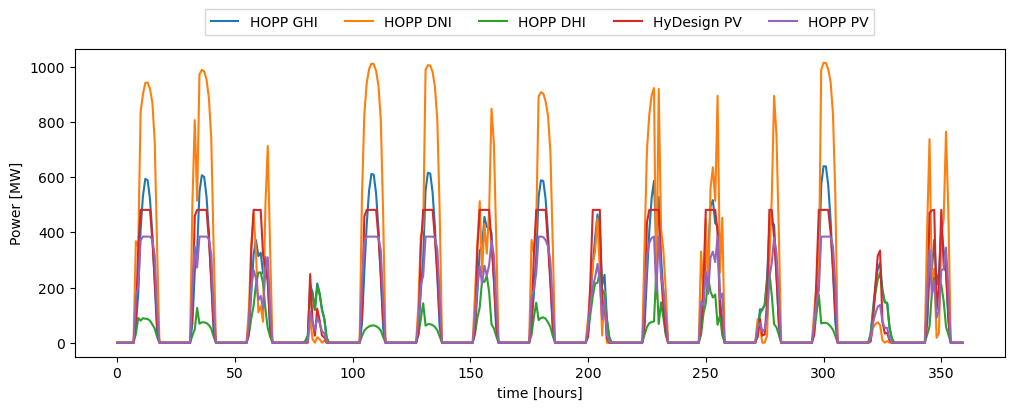

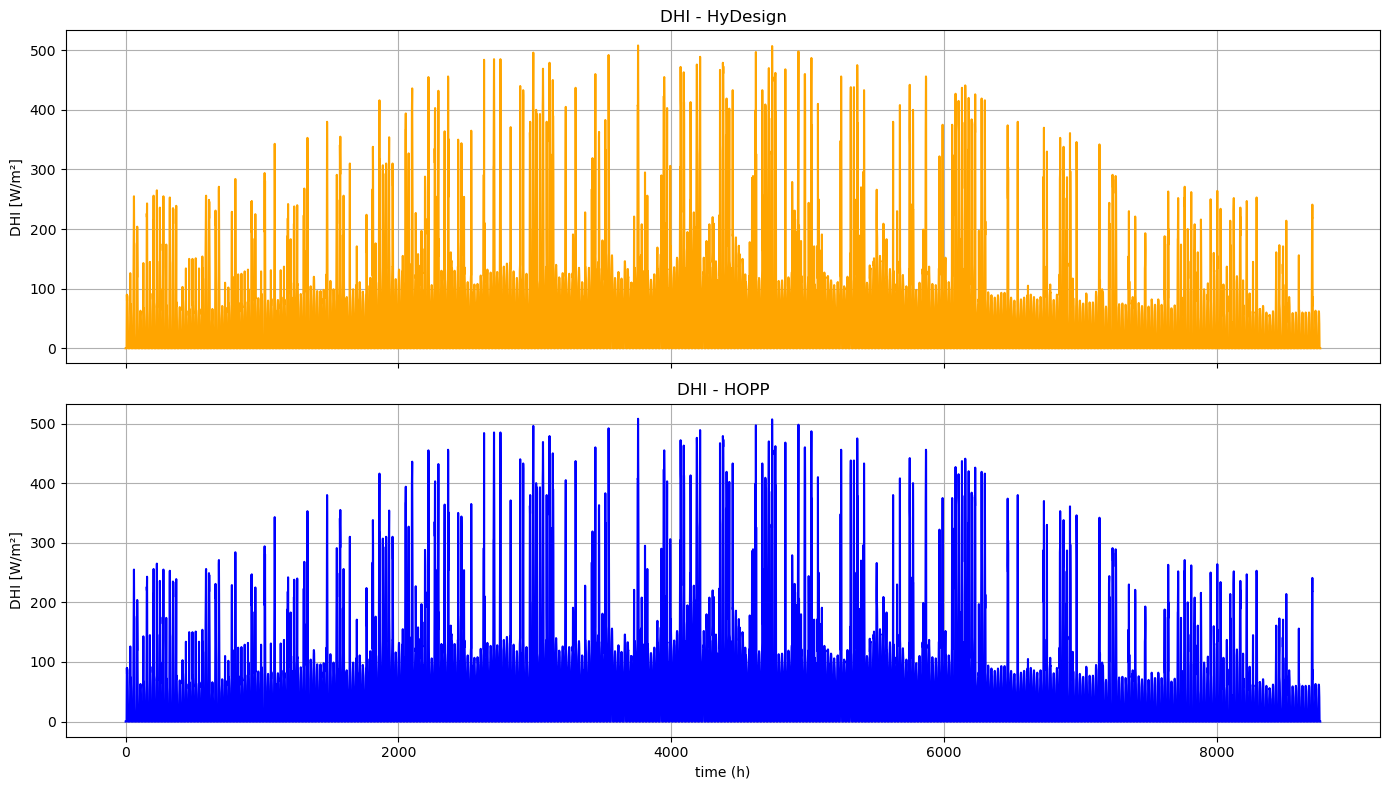

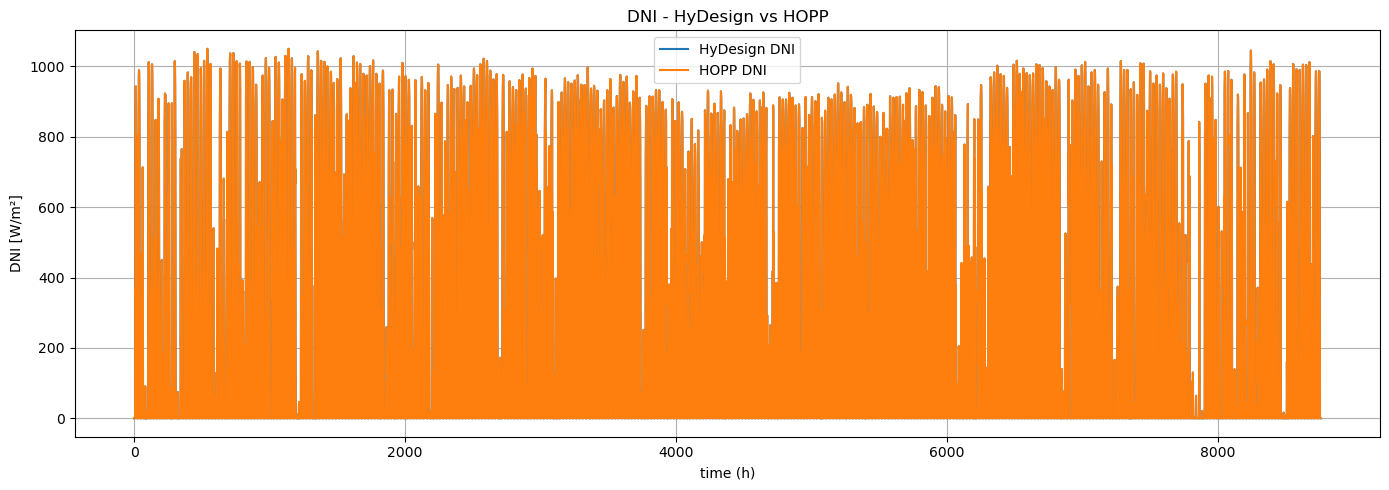

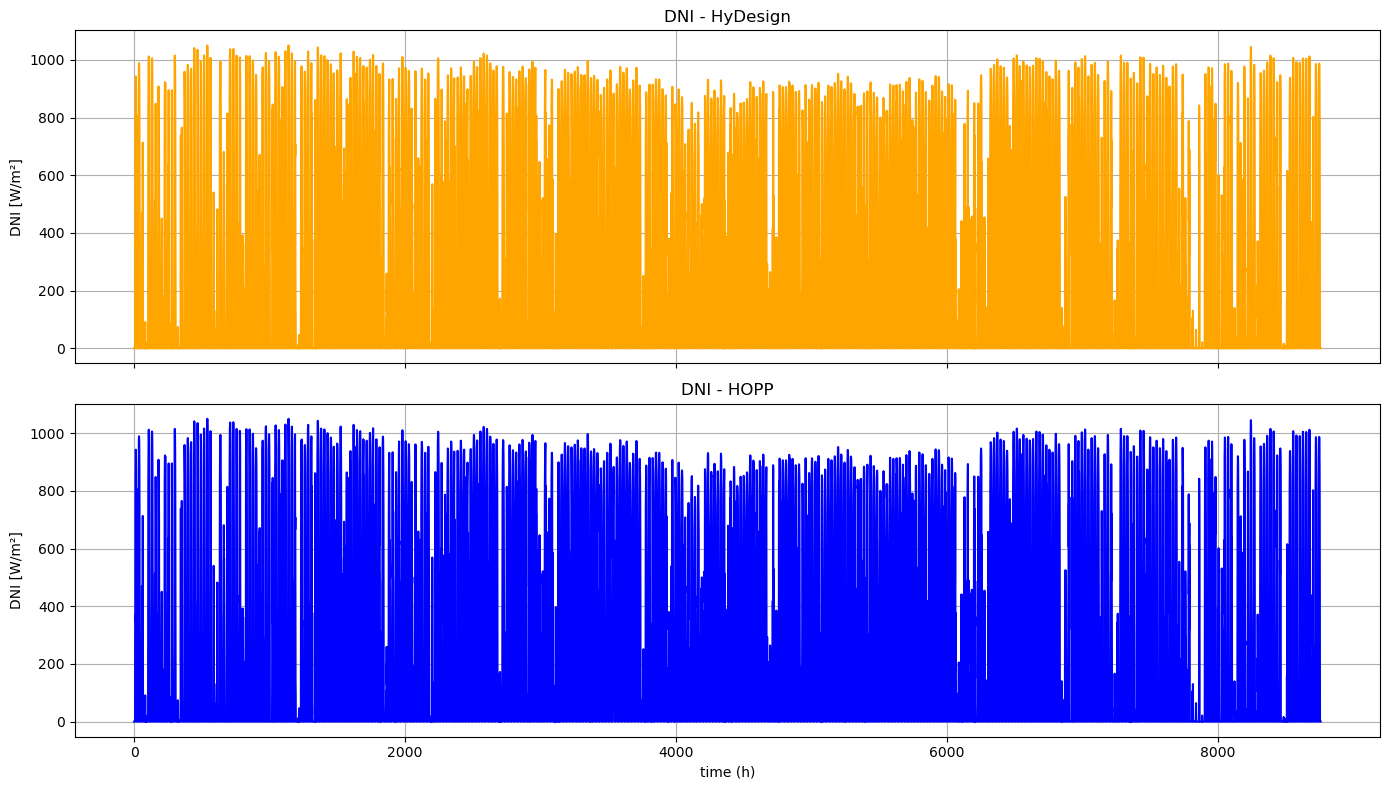

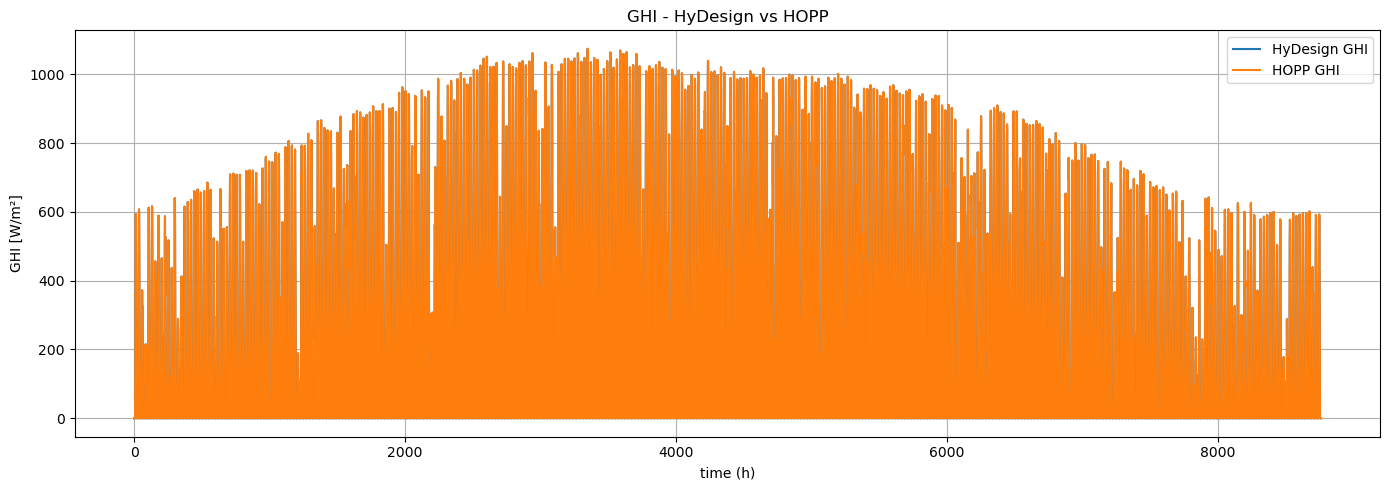

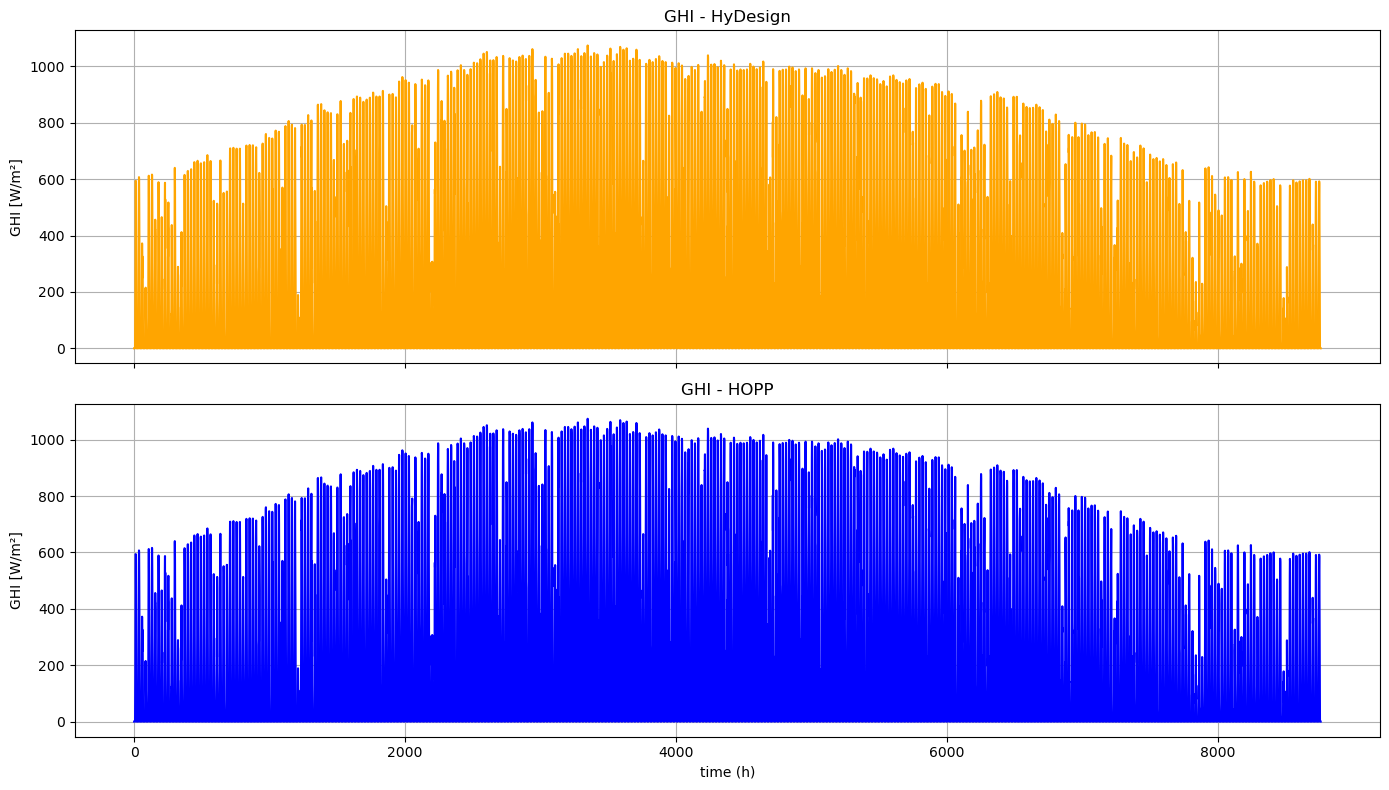

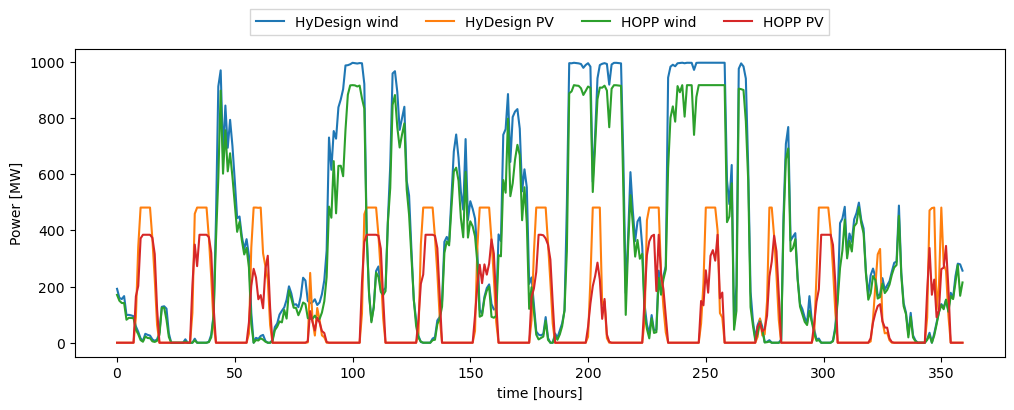

In [ ]:
# Compare the wind and solar generation between HOPP and Hydesign

base_dir = os.getcwd()

folder = 'hopp_input'
file = '34.22_-102.75_psmv3_60_2013.csv'
path = os.path.join(base_dir, folder, file)
df12 = pd.read_csv(path, skiprows=[0,1])

folder = 'hopp_input'
file = '34.22_-102.75_windtoolkit_2013_60min_100m_120m.srw'
path = os.path.join(base_dir, folder, file)
df1 = pd.read_csv(path, skiprows=[0,1,3,4])

folder = 'hopp_input'
file = 'texas-price.csv'
path = os.path.join(base_dir, folder, file)
df13 = pd.read_csv(path, skiprows=[])

folder = 'hydesign_input'
file = 'input_ts_template.csv'
path = os.path.join(base_dir, folder, file)
df2 = pd.read_csv(path, index_col=0)
df3 = pd.DataFrame({'WS_100': df1['Speed'].values,
                    'WD_100': df1['Direction'].values,
                    'WS_120': df1['Speed.1'].values,
                    'WD_120': df1['Direction.1'].values,
                    'temp_air_1': df12['Temperature'].values,
                    'ghi': df12['GHI'].values,
                    'dni': df12['DNI'].values,
                    'dhi': df12['DHI'].values,
                    'Price': df13['$/MWh'].values + 1e-9,
                    }, index=df2.index)
file = 'input_ts_texas.csv'
path = os.path.join(base_dir, folder, file)
df3['temp_air_1'] = df3['temp_air_1'] + 273.15 #HOPP has degree celsius
df3.to_csv(path)

### DHI PLOT ####

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax2 = plt.gca()
ax1.plot(df12['GHI'].values[:24*n_days_plot], label='HOPP GHI')
ax1.plot(df12['DNI'].values[:24*n_days_plot], label='HOPP DNI')
ax1.plot(df12['DHI'].values[:24*n_days_plot], label='HOPP DHI')
ax2.plot(solar_t[:24*n_days_plot], label='HyDesign PV')
ax2.plot(np.array(hybrid_plant.pv.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP PV')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('DHI [W/m2]')
ax2.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df3['dhi'].values, color='orange')
ax1.set_title('DHI - HyDesign')
ax1.set_ylabel('DHI [W/m²]')
ax1.grid(True)

ax2.plot(df12['DHI'].values, color='blue')
ax2.set_title('DHI - HOPP')
ax2.set_xlabel('time (h)')
ax2.set_ylabel('DHI [W/m²]')
ax2.grid(True)

plt.tight_layout()
plt.show()

### DNI PLOT ####
plt.figure(figsize=(14, 5))
plt.plot(df3['dni'].values, label='HyDesign DNI')
plt.plot(df12['DNI'].values, label='HOPP DNI')
plt.xlabel('time (h)')
plt.ylabel('DNI [W/m²]')
plt.title('DNI - HyDesign vs HOPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df3['dni'].values, color='orange')
ax1.set_title('DNI - HyDesign')
ax1.set_ylabel('DNI [W/m²]')
ax1.grid(True)

ax2.plot(df12['DNI'].values, color='blue')
ax2.set_title('DNI - HOPP')
ax2.set_xlabel('time (h)')
ax2.set_ylabel('DNI [W/m²]')
ax2.grid(True)

plt.tight_layout()
plt.show()

### GHI PLOT ####
plt.figure(figsize=(14, 5))
plt.plot(df3['ghi'].values, label='HyDesign GHI')
plt.plot(df12['GHI'].values, label='HOPP GHI')
plt.xlabel('time (h)')
plt.ylabel('GHI [W/m²]')
plt.title('GHI - HyDesign vs HOPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df3['ghi'].values, color='orange')
ax1.set_title('GHI - HyDesign')
ax1.set_ylabel('GHI [W/m²]')
ax1.grid(True)

ax2.plot(df12['GHI'].values, color='blue')
ax2.set_title('GHI - HOPP')
ax2.set_xlabel('time (h)')
ax2.set_ylabel('GHI [W/m²]')
ax2.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(wind_t[:24*n_days_plot], label='HyDesign wind')
ax1.plot(solar_t[:24*n_days_plot], label='HyDesign PV')
ax1.plot(np.array(hybrid_plant.wind.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP wind')
ax1.plot(np.array(hybrid_plant.pv.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP PV')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

Hydesign solar production : 14615.514499391718
HOPP solar production : 12038.593834905874


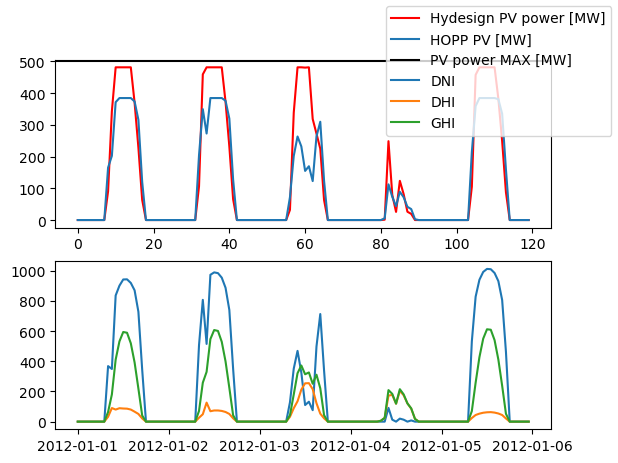

In [ ]:
import matplotlib.pyplot as plt
solar_t = hpp.prob['pvp.solar_t']
weather = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)
dni = weather["dni"]
dhi = weather["dhi"]
ghi = weather["ghi"]

time_start = 0
n_days = 5
fig, ax = plt.subplots(2,1)
ax[0].plot(solar_t[time_start: time_start + n_days * 24], color='red', label='Hydesign PV power [MW]')
ax[0].plot(np.array(hybrid_plant.pv.generation_profile[time_start: time_start + 24 *n_days]) / 1e3, label='HOPP PV [MW]')
ax[0].axhline(500, color='black', label='PV power MAX [MW]')
ax[1].plot(dni[time_start: time_start + n_days * 24], label='DNI')
ax[1].plot(dhi[time_start: time_start + n_days * 24], label='DHI')
ax[1].plot(ghi[time_start: time_start + n_days * 24], label='GHI')
fig.legend()

print("Hydesign solar production :", sum(solar_t[t] for t in range(n_days * 24)))
print("HOPP solar production :", sum(hybrid_plant.pv.generation_profile[t] for t in range(n_days * 24)) / 1e3)

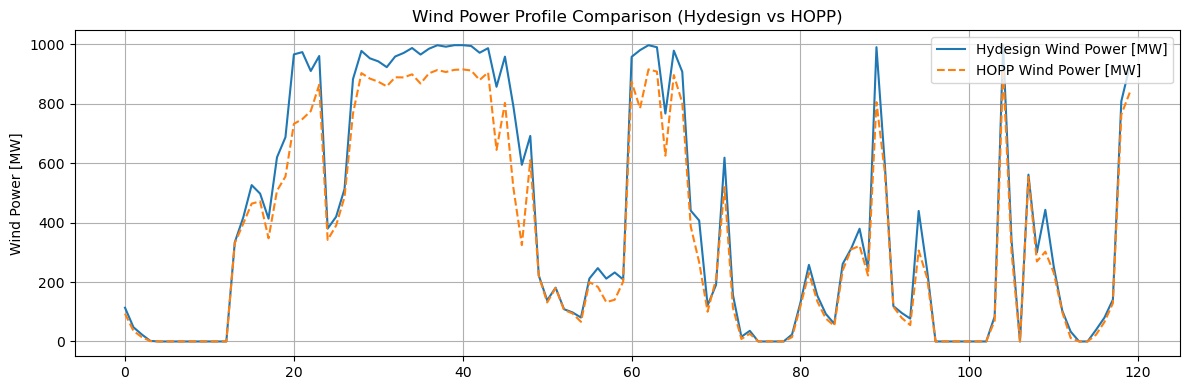

In [ ]:
wind_t = hpp.prob['wind_t']     
wind_hopp = np.array(hybrid_plant.wind.generation_profile) / 1e3 

time_start = 2000
n_days = 5
start = time_start
end = time_start + n_days * 24

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.plot(wind_t[start:end], label="Hydesign Wind Power [MW]")
plt.plot(wind_hopp[start:end], label="HOPP Wind Power [MW]", linestyle='--')

plt.title("Wind Power Profile Comparison (Hydesign vs HOPP)")
plt.ylabel("Wind Power [MW]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\1789981.py:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  weather_hopp = pd.read_csv(
C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\1789981.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_hopp = pd.read_csv(


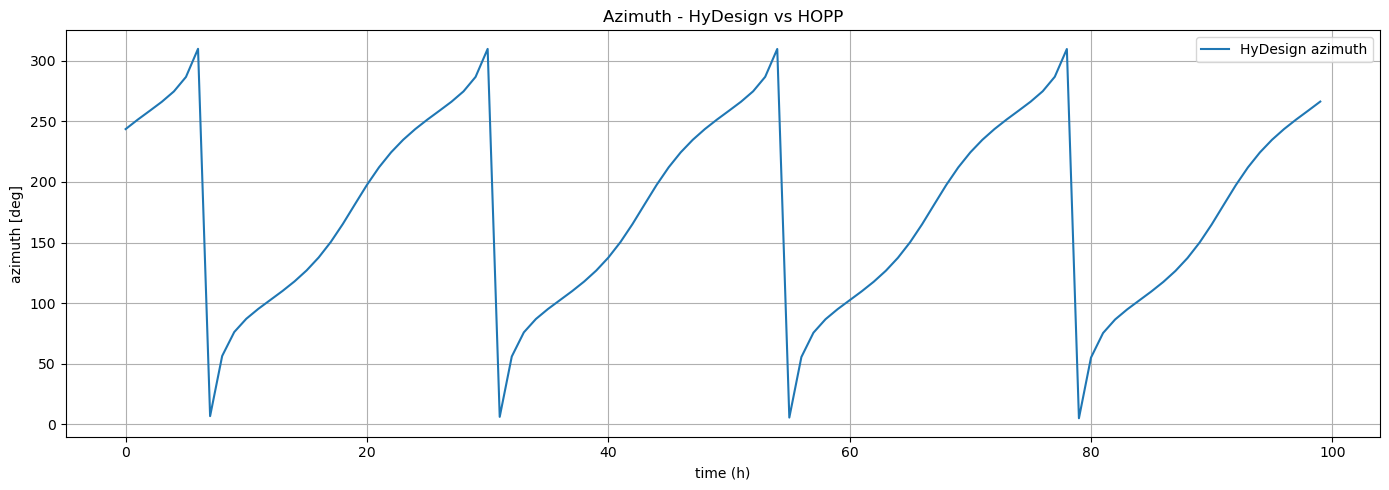

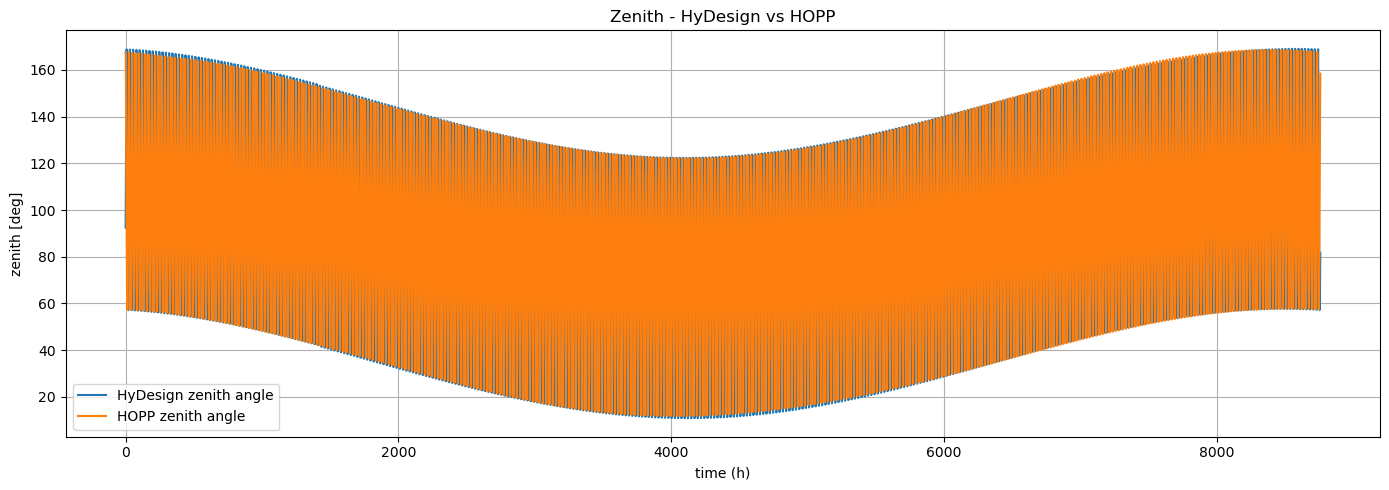

In [ ]:
from pvlib.location import Location     
from pvlib import atmosphere   

longitude, latitude, altitude

pvloc = Location(
            latitude=latitude,
            longitude=longitude,
            altitude=altitude,
            name='Plant')

weather_hydesign = pd.read_csv(input_ts_fn, index_col=0, parse_dates=True)
weather_hopp = pd.read_csv(
    r'C:\Users\s223344\tool-benchmarking\North_America\Texas\hopp_input\34.22_-102.75_psmv3_60_2013.csv',
    skiprows=2,
    parse_dates=[[0, 1, 2, 3, 4]],  # combine Year, Month, Day, Hour, Minute
    index_col=0
)

times = weather_hydesign.index
pressure = atmosphere.alt2pres(altitude)

solpos = pvloc.get_solarposition(times, pressure)

plt.figure(figsize=(14, 5))
plt.plot(solpos['azimuth'].values[0:100], label='HyDesign azimuth')
plt.xlabel('time (h)')
plt.ylabel('azimuth [deg]')
plt.title('Azimuth - HyDesign vs HOPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(solpos['zenith'].values, label='HyDesign zenith angle')
plt.plot(weather_hopp['Solar Zenith Angle'].values, label='HOPP zenith angle')
plt.xlabel('time (h)')
plt.ylabel('zenith [deg]')
plt.title('Zenith - HyDesign vs HOPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

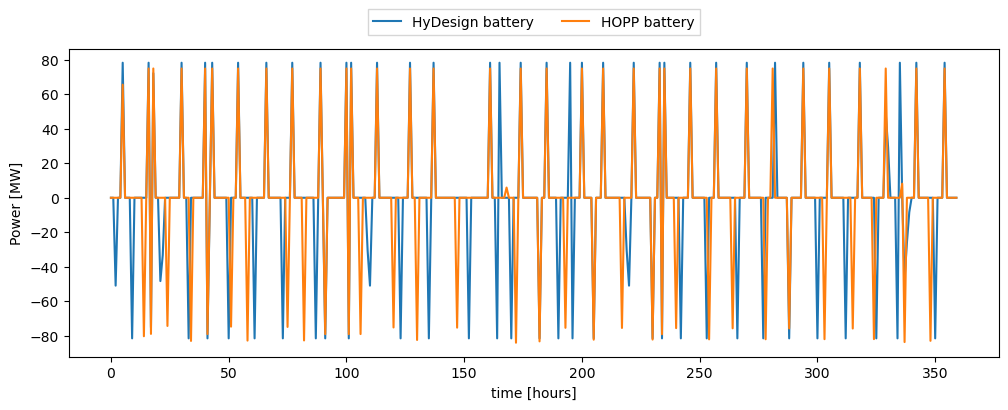

In [ ]:
# Compare the battery power time series between HOPP and Hydesign
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(b_t[:24*n_days_plot], label='HyDesign battery')
ax1.plot(np.array(hybrid_plant.battery.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP battery', color='tab:orange')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

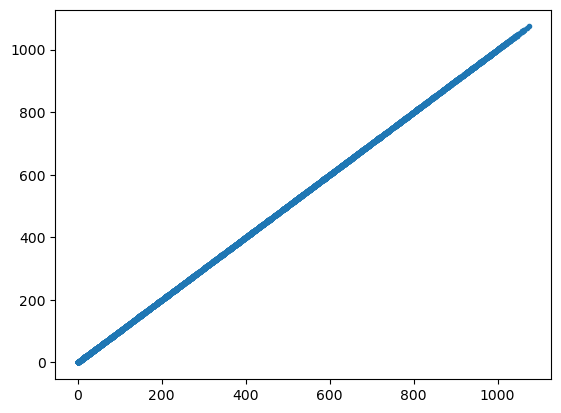

In [ ]:
plt.plot(df12['GHI'].values, ghi, '.')

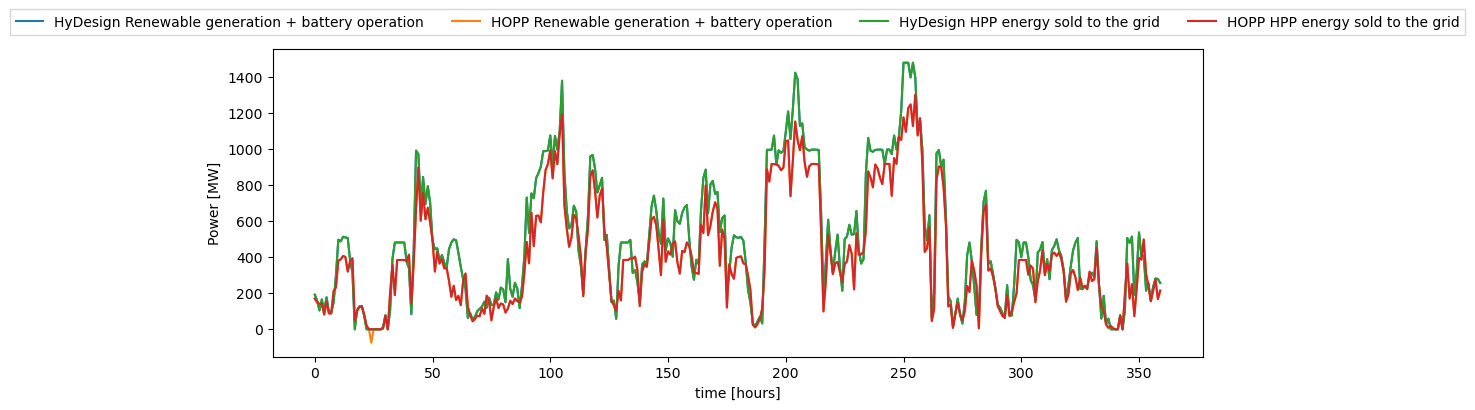

In [ ]:
# Compare the sum solar + wind + battery power between HOPP and Hydesign
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(wind_t[:24*n_days_plot] + solar_t[:24*n_days_plot] + b_t[:24*n_days_plot], label='HyDesign Renewable generation + battery operation')
ax1.plot(np.array(hybrid_plant.wind.generation_profile[:24*n_days_plot]) / 1e3 + np.array(hybrid_plant.pv.generation_profile[:24*n_days_plot]) / 1e3 + np.array(hybrid_plant.battery.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP Renewable generation + battery operation')
ax1.plot(hpp_t[:24*n_days_plot], label='HyDesign HPP energy sold to the grid')
ax1.plot(revenue_gen[:24*n_days_plot], label='HOPP HPP energy sold to the grid')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()


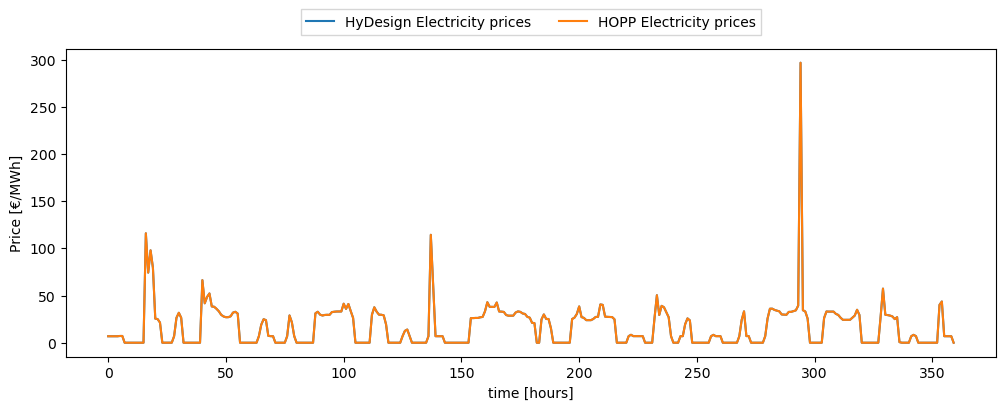

In [ ]:
# Compare the electricity prices between HOPP and Hydesign
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(price_t[:24*n_days_plot], label='HyDesign Electricity prices')
ax1.plot(np.array(hi.system.grid._financial_model.value('dispatch_factors_ts')[:24*n_days_plot]), label='HOPP Electricity prices') # Without the PPA price input ! 
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Price [€/MWh]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

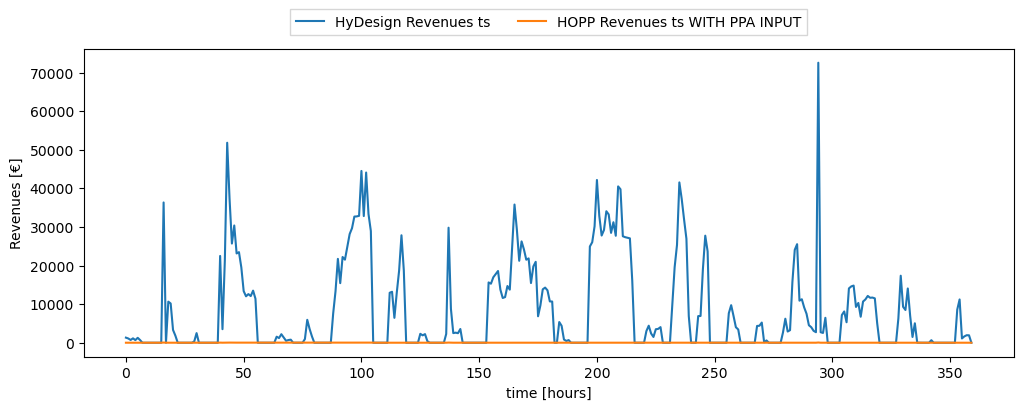

In [ ]:
# Same as below. Removing the ppa price input is equivalent to shift from a price €/kWh to a price in €/MWh.
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(hpp_t[:24*n_days_plot]*price_t[:24*n_days_plot], label='HyDesign Revenues ts')
ax1.plot(np.array(revenue_gen[:24*n_days_plot]*hi.system.grid._financial_model.value('dispatch_factors_ts')[:24*n_days_plot]) * np.array(hi.system.grid._financial_model.value('ppa_price_input')), label='HOPP Revenues ts WITH PPA INPUT') # Without the PPA price input ! 
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Revenues [€]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

In [ ]:
import json

with open("singleowner.json", 'w') as f:
    dat = hybrid_plant.grid._financial_model.export()
    d = dict()
    for k, v in dat.items():
        d.update(v)
    json.dump(d, f)

In [ ]:
euro_per_dollar = 1.0
df = pd.DataFrame({'HOPP': [wind_installed_cost/1e6*euro_per_dollar,
                            solar_installed_cost/1e6*euro_per_dollar,
                            battery_installed_cost/1e6*euro_per_dollar,
                            hybrid_installed_cost/1e6*euro_per_dollar,
                            sum(OM_cost["wind"]) / 1e6 * euro_per_dollar,
                            sum(OM_cost["pv"]) / 1e6 * euro_per_dollar,
                            sum(OM_cost["battery"]) / 1e6 * euro_per_dollar,
                            sum(OM_cost["hybrid"]) / 1e6 * euro_per_dollar,
                            hybrid_plant.net_present_values.hybrid/1e6*euro_per_dollar,
                           ],
                   'HyDesign': [float(hpp.prob['wpp_cost.CAPEX_w']/1e6),
                                float(hpp.prob['pvp_cost.CAPEX_s']/1e6),
                                float(hpp.prob['battery_cost.CAPEX_b']/1e6),
                                float(hpp.prob['CAPEX']/1e6),
                                float(hpp.prob['wpp_cost.OPEX_w'] * 25 /1e6),
                                float(hpp.prob['pvp_cost.OPEX_s'] * 25/1e6),
                                float(hpp.prob['battery_cost.OPEX_b'] * 25/1e6),
                                float(hpp.prob['OPEX'] * 25/1e6),
                                float(hpp.prob['NPV']/1e6),
                                ] },
                  index=['CAPEX Wind [M€]',
                         'CAPEX Solar [M€]',
                         'CAPEX Battery [M€]',
                         'CAPEX Hybrid [M€]',
                         'OPEX Wind [M$]',
                         'OPEX Solar [M$]',
                         'OPEX Battery [M$]',
                         'OPEX Hybrid [M$]',
                         'NPV Hybrid [M€]',
                        ])

C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\474329582.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'HyDesign': [float(hpp.prob['wpp_cost.CAPEX_w']/1e6),
C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\474329582.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(hpp.prob['pvp_cost.CAPEX_s']/1e6),
C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\474329582.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(hpp.prob['battery_cost.

In [ ]:
df

,HOPP,HyDesign
CAPEX Wind [M€],1152.900000,1152.900000
CAPEX Solar [M€],495.500000,495.500000
CAPEX Battery [M€],37.000000,68.600000
CAPEX Hybrid [M€],1685.400000,1817.000000
OPEX Wind [M$],867.700820,677.250000
OPEX Solar [M$],275.460578,215.000000
OPEX Battery [M$],29.628027,23.125000
OPEX Hybrid [M$],1172.789424,915.375000
NPV Hybrid [M€],631.683268,-479.660769


In [ ]:
hpp.prob.model.list_outputs()

49 Explicit Output(s) in 'model'

varname                               val                   prom_name                 
------------------------------------  --------------------  --------------------------
abl
  wst                                 |764.04689557|        wst                       
genericWT
  ws                                  |117.70938833|        ws                        
  pc                                  |5.89355999|          pc                        
  ct                                  |3.0492523|           ct                        
genericWake
  pcw                                 |6097.2383766|        pcw                       
wpp
  wind_t                              |58108.34257392|      wind_t                    
pvp
  solar_t                             |22317.2661989|       solar_t                   
  Apvp                                [0.]                  Apvp                      
ems
  wind_t_ext                          |290541.71286961|   

[('abl.wst',
  {'val': array([5.50530148, 5.17884758, 5.13630554, ..., 6.49699958, 7.10720779,
          7.08588905], shape=(8760,)),
   'prom_name': 'wst'}),
 ('battery_cost.CAPEX_b', {'val': array([68600000.]), 'prom_name': 'CAPEX_b'}),
 ('battery_cost.OPEX_b', {'val': array([925000.]), 'prom_name': 'OPEX_b'}),
 ('battery_degradation.SoH',
  {'val': array([0.99995228, 0.99993402, 0.99991576, ..., 0.        , 0.        ,
          0.        ], shape=(219000,)),
   'prom_name': 'SoH'}),
 ('battery_degradation.n_batteries',
  {'val': array([3.]), 'prom_name': 'n_batteries'}),
 ('battery_loss_in_capacity_due_to_temp.SoH_all',
  {'val': array([0.84662627, 0.83327835, 0.83326313, ..., 0.        , 0.        ,
          0.        ], shape=(219000,)),
   'prom_name': 'SoH_all'}),
 ('battery_with_reliability.b_t_rel',
  {'val': array([  0.        ,   0.        , -51.02040816, ...,   0.        ,
            0.        , -30.6122449 ], shape=(219000,)),
   'prom_name': 'b_t_rel'}),
 ('ems.wind_t_

In [ ]:
import numpy as np
import pandas as pd

outputs_keys = [ 
    "NPV", "LCOE", "Revenues", "CAPEX", "OPEX",
    "CAPEX_wind", "OPEX_wind", "CAPEX_solar", "OPEX_solar",
    "CAPEX_battery", "OPEX_battery", "CAPEX_infra_elec", "OPEX_infra_elec",
    "mean_AEP", "wind_capacity", "solar_capacity",
    "battery_power_capacity", "battery_energy_capacity", 
    "total_curtailment"
]

# --- Global outputs ---
price_t_lifetime = np.tile(price_t, 25)

outputs_hydesign = {
    "NPV": float(hpp.prob['NPV']/1e6),
    "LCOE": float(hpp.prob['LCOE']),  
    "Revenues": float(np.sum(hpp_t * price_t_lifetime)/1e6), 
    "CAPEX": float(hpp.prob['CAPEX']/1e6),
    "OPEX": float(hpp.prob['OPEX'] * 25/1e6),  
    "CAPEX_wind": float(hpp.prob['wpp_cost.CAPEX_w']/1e6),
    "OPEX_wind": float(hpp.prob['wpp_cost.OPEX_w'] * 25/1e6),
    "CAPEX_solar": float(hpp.prob['pvp_cost.CAPEX_s']/1e6),
    "OPEX_solar": float(hpp.prob['pvp_cost.OPEX_s'] * 25/1e6),
    "CAPEX_battery": float(hpp.prob['battery_cost.CAPEX_b']/1e6),
    "OPEX_battery": float(hpp.prob['battery_cost.OPEX_b'] * 25/1e6),
    "CAPEX_infra_elec": float(hpp.prob['finance.CAPEX_el']/1e6),
    "OPEX_infra_elec": float(hpp.prob['finance.OPEX_el'] * 25/1e6),
    "mean_AEP": float(np.mean(wind_t + solar_t)),  
    "wind_capacity": float(inputs['Nwt'] * inputs['p_rated']), 
    "solar_capacity": float(inputs['solar_MW']),
    "battery_power_capacity": float(inputs['b_P']),
    "battery_energy_capacity": float(inputs['b_E_h']*inputs['b_P']),
    "total_curtailment": float(np.sum(hpp_curt_t)/1e9),
}

outputs_hopp = {
    "NPV": float(hybrid_plant.net_present_values.hybrid)/1e6,
    "LCOE": float(hybrid_plant.lcoe_real['hybrid']*10),
    "Revenues": float(np.sum(total_revenue))/1e6,
    "CAPEX": float(hybrid_installed_cost)/1e6,
    "OPEX": float(sum(OM_cost["hybrid"]))/1e6,
    "CAPEX_wind": float(wind_installed_cost)/1e6,
    "OPEX_wind": float(sum(OM_cost["wind"]))/1e6,
    "CAPEX_solar": float(solar_installed_cost)/1e6,
    "OPEX_solar": float(sum(OM_cost["pv"]))/1e6,
    "CAPEX_battery": float(battery_installed_cost)/1e6,
    "OPEX_battery": float(sum(OM_cost["battery"]))/1e6,
    "CAPEX_infra_elec": float(hybrid_installed_cost - wind_installed_cost - solar_installed_cost - battery_installed_cost)/1e6,
    "OPEX_infra_elec": float(sum(OM_cost["hybrid"]) - sum(OM_cost["wind"]) - sum(OM_cost["pv"]) - sum(OM_cost["battery"]))/1e6,
    "mean_AEP": float(np.mean(hybrid_plant.annual_energies.hybrid)),  
    "wind_capacity": float(hybrid_plant.wind.config.num_turbines * hybrid_plant.wind.config.turbine_rating_kw)/1e3,
    "solar_capacity": float(hybrid_plant.pv.config.system_capacity_kw)/1e3,
    "battery_power_capacity": float(hybrid_plant.battery.config.system_capacity_kw)/1e3,
    "battery_energy_capacity": float(hybrid_plant.battery.config.system_capacity_kwh)/1e3,
    "total_curtailment": float(sum(hybrid_plant.grid.generation_curtailed))/1e6,
}

outputs_keys_overall = [key for key in outputs_keys if key != "mean_AEP"]

df_hopp_hydesign = pd.DataFrame({
    "Output": outputs_keys_overall,
    "Hydesign": [outputs_hydesign[key] for key in outputs_keys_overall],
    "HOPP": [outputs_hopp[key] for key in outputs_keys_overall]
})

years = list(range(1, 26))

hopp_annual_revenues = np.array(hybrid_plant.grid._financial_model.value('revenue_gen')) / 1e6
hpp_t_array = np.array(hpp_t)
price_t_array = np.array(price_t)
hydesign_annual_revenues = [
    np.sum(hpp_t_array[year*8760:(year+1)*8760] * price_t_array) / 1e6
    for year in range(25)
]

hopp_annual_opex = np.array(OM_cost["hybrid"]) / 1e6
hydesign_annual_opex = [float(hpp.prob['OPEX']) / 1e6] * 25

hydesign_annual_AEP = np.array([np.sum(wind_t[year*8760:(year+1)*8760] + solar_t[year*8760:(year+1)*8760])/1e3 for year in range(25)])

hopp_annual_AEP = np.array([np.sum(hybrid_plant.pv.generation_profile[year*8760:(year+1)*8760] + hybrid_plant.wind.generation_profile[year*8760:(year+1)*8760])/1e3 for year in range(25)])

df_annual = pd.DataFrame({
    "Year": years,
    "Revenues_Hydesign [M€]": hydesign_annual_revenues,
    "Revenues_HOPP [M€]": np.array(total_revenue[1:26]) / 1e6,
    "OPEX_Hydesign [M€]": hydesign_annual_opex,
    "OPEX_HOPP [M€]": hopp_annual_opex[1:26],
    "AEP_Hydesign [MWh]": hydesign_annual_AEP,
    "AEP_HOPP [MWh]": hopp_annual_AEP
})

with pd.ExcelWriter("compare_hydesign_hopp_texas.xlsx", engine='openpyxl') as writer:
    df_hopp_hydesign.to_excel(writer, sheet_name='Overall_Comparison', index=False)
    df_annual.to_excel(writer, sheet_name='Annual_Comparison', index=False)

print("Export done: compare_hydesign_hopp.xlsx with two sheets")
print("  - Overall_Comparison: Global metrics (mean_AEP removed)")
print("  - Annual_Comparison: Annual Revenues, OPEX, and AEP")

C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\2261104386.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "NPV": float(hpp.prob['NPV']/1e6),
C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\2261104386.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "LCOE": float(hpp.prob['LCOE']),
C:\Users\s223344\AppData\Local\Temp\ipykernel_23588\2261104386.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "CAPEX": float(hpp.prob['CAPEX']/1e6),
C:\Users\s2233

Export done: compare_hydesign_hopp.xlsx with two sheets
  - Overall_Comparison: Global metrics (mean_AEP removed)
  - Annual_Comparison: Annual Revenues, OPEX, and AEP
